# Price Prediction

In [1]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import code from __scrape__ notebook

In [2]:
import ipynb.fs  # Boilerplate required
from .defs.scrape import loadHistoricalData

## Load historical data into a dataframe

In [3]:
df = loadHistoricalData()
# some constants
COL_VOLUME = "volume"
COL_MARKET = "market"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
WINDOW = 30
df.head()

,name,open,high,low,close,volume,market
date,,,,,,,
2018-01-26,BTC,11256.0,11656.7,10470.3,11171.4,9746200000,189398000000
2018-01-25,BTC,11421.7,11785.7,11057.4,11259.4,8873170000,192163000000
2018-01-24,BTC,10903.4,11501.4,10639.8,11359.4,9940990000,183419000000
2018-01-23,BTC,10944.5,11377.6,10129.7,10868.4,9660610000,184087000000
2018-01-22,BTC,11633.1,11966.4,10240.2,10931.4,10537400000,195645000000


In [4]:
currency = "XRP"
#Extracting the bitcoin data from the dataframe
dfC=df[df['name']==currency].copy()
#Just dropping columns here!
dfC.drop(['name', 'volume', 'market'],axis=1,inplace=True)
#We don't have any NaN values luckily
dfC.isnull().any()

open     False
high     False
low      False
close    False
dtype: bool

In [5]:
dfC.sort_index(ascending=True, inplace=True)
dfC.head()#Our data is pretty up to date it seems! 

,open,high,low,close
date,,,,
2013-08-04,0.005874,0.005927,0.005874,0.005882
2013-08-05,0.005875,0.005980,0.005613,0.005613
2013-08-06,0.005637,0.005661,0.004629,0.004680
2013-08-07,0.004669,0.004682,0.004333,0.004417
2013-08-08,0.004397,0.004424,0.004175,0.004254


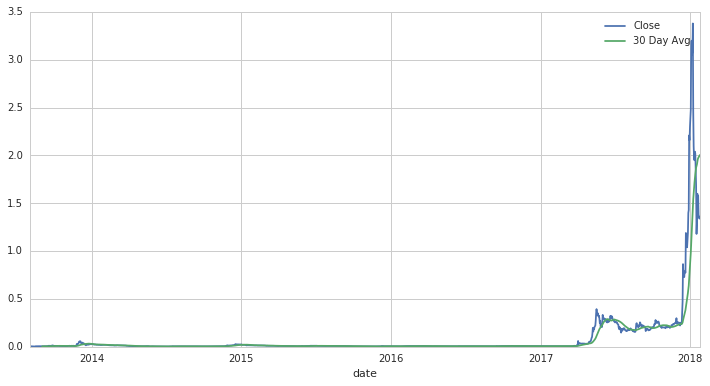

In [6]:
sns.set()
sns.set_style('whitegrid')
dfC['close'].plot(figsize=(12,6),label='Close')
dfC['close'].rolling(window=WINDOW).mean().plot(label='{} Day Avg'.format(WINDOW))# Plotting the 
#rolling 30 day average against the Close Price
plt.legend()

In [7]:
#I will be adding a feature to improve the model.This feature is provided by Tafarel Yan in his Kernel

dfC['ohlc_average'] = (dfC['open'] + dfC['high'] + dfC['low'] + dfC['close']) / 4

,open,high,low,close,ohlc_average
date,,,,,
2013-08-04,0.005874,0.005927,0.005874,0.005882,0.005889
2013-08-05,0.005875,0.005980,0.005613,0.005613,0.005770
2013-08-06,0.005637,0.005661,0.004629,0.004680,0.005152
2013-08-07,0.004669,0.004682,0.004333,0.004417,0.004525
2013-08-08,0.004397,0.004424,0.004175,0.004254,0.004312


In [8]:
dfC['Price_After_Month']=dfC['close'].shift(-WINDOW) #This will be our label
dfC.tail()#We basically moved all our values 30 lines up in our last cell
# drop data
dfC = dfC[dfC.index.year >= 2016]

In [9]:
#Preprocessing
from sklearn import preprocessing
dfC.dropna(inplace=True)
X=dfC.drop('Price_After_Month',axis=1)
X=preprocessing.scale(X)#We need to scale our values to input them in our model
y=dfC['Price_After_Month']

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

In [11]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 18.894 %


In [12]:
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])
#We can see that our predictions are kind of accurate but we still need to work on on them a lot.

The prediction is: 0.007933418563933698 But the real value is: 0.008834999999999999


In [13]:
#Apply our model and get our prediction
X_WINDOW=X[-WINDOW:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_WINDOW)

In [14]:
#creating a new column which contains the predictions! 
#Proceed at your own risk!  
from datetime import datetime, timedelta
last_date=dfC.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=WINDOW,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
dfC=dfC.append(df1)
dfC.tail()

,Forecast,Price_After_Month,close,high,low,ohlc_average,open
2018-01-20,1.52725,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,1.43225,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-22,1.38800,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-23,1.37285,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-24,1.38535,NaN,NaN,NaN,NaN,NaN,NaN


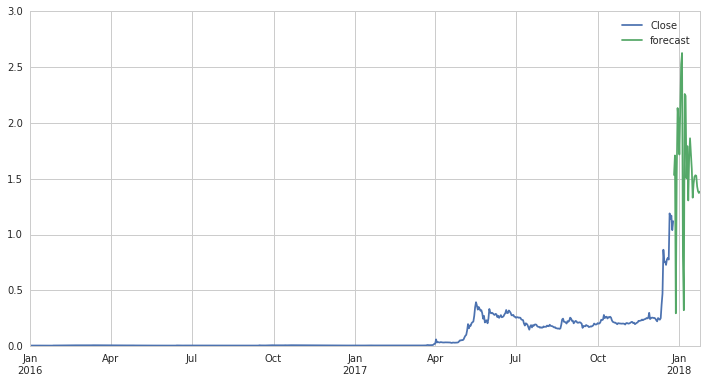

In [15]:
#Now we'll plot our forecast! 
dfC['close'].plot(figsize=(12,6),label='Close')
dfC['Forecast'].plot(label='forecast')
plt.legend()